In [1]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sbn
import matplotlib.pyplot as plt
import seaborn as sns

#import bokeh.palettes

plt.rcParams['svg.fonttype'] = 'none'

sns.set_context("paper")
sns.set_style("white")

# Mutation data process rules

In [2]:
mut_df=pd.read_csv("../Data/Mutation_data/strain_mutation_table.tsv", sep="\t")
mut_df=mut_df.rename(columns={"Unnamed: 0":"mut_id"})

In [3]:
mut_df.head(3)

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA4-2,HMDA4-6,HMDA4-9,...,BUT9-7,BUT9-10,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU5-1,GLU6-1,GLU7-1,GLU8-1
0,SNP-3816611-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,SNP-2694102-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SNP-4257602-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
f = open("../Data/Mutation_data/Mutations_to_gene_names.json")
mut_to_genes=json.load(f)
data_list=list(mut_to_genes.items())
mut_to_genes=pd.DataFrame(data_list, columns=['mut','Gene'])

In [5]:
for i in mut_df.index:
    mut_df.loc[i,'mutation_type']=mut_df.loc[i,'mut_id'].split("-")[0]
    mut_df.loc[i,'start']=mut_df.loc[i,'mut_id'].split("-")[1]
    #mut_df.loc[i,'mutation_type']=''.join([str(item) for item in mut_df.loc[i,'mutation_type']])

In [6]:
#Drop MOB and DUP mutation information
mut_df=mut_df[(mut_df['mutation_type']!='DUP')]

In [7]:
mut_df.head()

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA4-2,HMDA4-6,HMDA4-9,...,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU5-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start
0,SNP-3816611-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,3816611
1,SNP-2694102-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,2694102
2,SNP-4257602-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,4257602
3,SNP-962939-A,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,962939
4,SNP-4181786-T,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SNP,4181786


In [8]:
for i in mut_df.index:
    mut_df.loc[i,'Gene']= mut_to_genes[mut_to_genes['mut']==mut_df.loc[i,'mut_id']].Gene.values
    if len( mut_df.loc[i,'Gene'])==0:
         mut_df.loc[i,'Gene']=""
    else:
        mut_df.loc[i,'Gene']=','.join(str(item) for item in mut_df.loc[i,'Gene'])
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("[","")
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("]","")
        mut_df.loc[i,'Gene']=mut_df.loc[i,'Gene'].replace("'","")

In [9]:
mut_df['start']=mut_df['start'].astype('int64')
mut_df=mut_df.sort_values(by="start")
mut_df=mut_df.reset_index(drop=True)

In [10]:
#Drop hypermutator

In [11]:
hypermutators_df=pd.read_csv("../Data/Mutation_data/hypermutators_list_glc.csv")

In [12]:
hypermutators_df.index.size

32

In [13]:
mut_df=mut_df.drop(columns=hypermutators_df['strain_code'])
mut_df=mut_df[mut_df.iloc[:,2:-3].sum(axis=1)!=0]

In [14]:
mut_df.head()

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene
0,SNP-2374-T,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,2374,thrA
11,SNP-20771-A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,20771,insA
42,SNP-64352-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,64352,polB
55,SNP-82594-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SNP,82594,leuA
58,DEL-83679-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,DEL,83679,leuL


In [15]:
mut_df.columns.to_list()

['mut_id',
 'HMDA1-10',
 'HMDA2-1',
 'HMDA2-8',
 'HMDA3-4',
 'HMDA3-5',
 'HMDA3-6',
 'HMDA5-4',
 'HMDA5-5',
 'HMDA5-10',
 'HMDA7-1',
 'HMDA7-7',
 'HMDA7-10',
 'HMDA8-5',
 'HMDA8-9',
 'HMDA8-10',
 'PUTR2-4',
 'PUTR2-6',
 'PUTR3-1',
 'PUTR3-9',
 'PUTR3-10',
 'PUTR4-3',
 'PUTR4-7',
 'PUTR4-8',
 'PUTR5-1',
 'PUTR5-6',
 'PUTR5-8',
 'PUTR6-2',
 'PUTR6-7',
 'PUTR6-10',
 'PUTR7-1',
 'PUTR7-7',
 'PUTR7-9',
 'PUTR8-3',
 'PUTR8-6',
 'PUTR8-10',
 '12PD4-6',
 '12PD6-3',
 '12PD6-9',
 '23BD1-6',
 '23BD1-9',
 '23BD2-4',
 '23BD2-7',
 '23BD2-9',
 '23BD4-3',
 '23BD4-4',
 '23BD4-7',
 '23BD5-1',
 '23BD5-7',
 '23BD5-10',
 '23BD6-1',
 '23BD7-4',
 '23BD7-5',
 '23BD7-7',
 '23BD8-2',
 '23BD8-7',
 'GLUT1-3',
 'GLUT1-9',
 'GLUT1-10',
 'GLUT2-1',
 'GLUT2-9',
 'GLUT2-10',
 'GLUT3-5',
 'GLUT3-7',
 'GLUT3-9',
 'GLUT4-1',
 'GLUT4-4',
 'GLUT4-10',
 'GLUT5-4',
 'GLUT5-5',
 'GLUT5-9',
 'GLUT6-4',
 'GLUT6-5',
 'GLUT6-10',
 'GLUT7-2',
 'GLUT7-6',
 'GLUT7-7',
 'GLUT8-5',
 'GLUT8-6',
 'GLUT8-9',
 'ADIP1-1',
 'ADIP1-9',
 'ADI

# Identifying frequently mutated operon

In [16]:
#Read gene_table containing operon (i.e., transcriotion unit) information from Ecocyc

In [17]:
gene_table = pd.read_csv("../Data/gene_info_GenBank.csv", index_col=0)  # Unique to this NB
gene_table.gene_name=gene_table.gene_name.str.replace('-','')
gene_table.start=gene_table.start.astype('int64')
gene_table.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
b0001,thrL,NC_000913.3,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86,Op0
b0002,thrA,NC_000913.3,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561,Op0
b0003,thrB,NC_000913.3,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547,Op0
b0004,thrC,NC_000913.3,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934,Op0
b0005,yaaX,NC_000913.3,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616,Op1


#Manually added gene name

b1522 dgcF -> YneF
b0022 insA1 -> insA
b1917 tcyN -> yecC
b1918 -> yecS

b1920 -> fliY
b1934 newly added

b1956 ydeQ
yedS

b2092 gatC
b2352 -> gtrS


b3423 glpR



# Process deletions in multiple genes

In [18]:
#count gene numbers mutated by a single mutation event

for i in mut_df.index:
    mut_df.Gene = mut_df.Gene.str.replace(' ', '')
    mut_df.loc[i,'gene_num']=len(mut_df.loc[i,'Gene'].split(','))

In [19]:
gene_table.gene_name=gene_table.gene_name.str.replace('-','')

In [20]:
#split deletion of multiple genes into multiple rows
#Index for newly added rows will be "original index-1,2,3,...""

for i in mut_df[mut_df['gene_num']!=1].index:
    multiple_gene_names = mut_df.loc[i,'Gene'].split(',')

    temp1 = mut_df.loc[i]

    for j in range(0,len(multiple_gene_names)):
        temp1.Gene=multiple_gene_names[j]
        temp1.start=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
        temp1.name=str(mut_df.loc[i].name)+'-'+str(j+1)
        mut_df=mut_df.append(pd.Series(temp1))

    mut_df=mut_df.drop([i])

/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.Gene=multiple_gene_names[j]
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.start=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))

/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_

/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/var/folders/17/6t040btj329d3snp5tbspqtr0000gn/T/ipykernel_53638/2536655973.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_

In [21]:
mut_df

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene,gene_num
0,SNP-2374-T,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,SNP,2374,thrA,1.0
11,SNP-20771-A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,SNP,20771,insA,1.0
42,SNP-64352-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,SNP,64352,polB,1.0
55,SNP-82594-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,SNP,82594,leuA,1.0
58,DEL-83679-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,83679,leuL,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255-2,DEL-2911491-7528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2913699,rlmD,4.0
2255-3,DEL-2911491-7528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2915057,barA,4.0
2255-4,DEL-2911491-7528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2918045,gudD,4.0
2892-1,DEL-3815859-82,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,DEL,3815863,rph,2.0


In [22]:
#Some gene names are duplicated in a deleted gene list causing a duplication of rows. e.g., crl
mut_df[mut_df.duplicated()]

,mut_id,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,...,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,mutation_type,start,Gene,gene_num
164-5,DEL-255591-18364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,257829,crl,27.0
164-26,DEL-255591-18364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,270278,insN,27.0
169-20,DEL-260217-13738,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,270278,insN,21.0
1567-20,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2011223,yedN,50.0
1567-21,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2011223,yedN,50.0
1567-50,DEL-1995819-40006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2035835,yedS,50.0
2150-7,DEL-2801966-11843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,DEL,2808316,ygaY,12.0
2892-2,DEL-3815859-82,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,DEL,3815863,rph,2.0


In [23]:
mut_df=mut_df.drop_duplicates()

In [24]:
#Gene number information is no longer needed
mut_df=mut_df.drop(columns=['gene_num'])

In [25]:
mut_df=mut_df.drop(index=(mut_df[mut_df.Gene==''].index))

In [26]:
#Sort the mutation table by "start" and reindex
mut_df=mut_df.sort_values(by=['start'])
mut_df=mut_df.reset_index(drop=True)

In [27]:
gene_list=mut_df['Gene'].unique().tolist()

In [28]:
#total mutated gene number
len(gene_list)

386

# Create a new DataFrame for mutation frequency information

In [29]:
# Unique_df contains information about mutation frequency only for a given gene

In [30]:
unique_df=pd.DataFrame(columns=mut_df.columns)

In [31]:
#sum mutation frequencies if occured in the same gene

In [32]:
for i in gene_list:
    subset_df= mut_df[mut_df.Gene==i]
    unique_df.loc[i]=subset_df.sum(axis=0)

In [33]:
drop_col={'mut_id','mutation_type','start','Gene',
}

unique_df=unique_df.drop(columns=drop_col)

In [34]:
unique_df

,HMDA1-10,HMDA2-1,HMDA2-8,HMDA3-4,HMDA3-5,HMDA3-6,HMDA5-4,HMDA5-5,HMDA5-10,HMDA7-1,...,BUT7-9,BUT9-7,BUT9-10,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
thrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
insA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
polB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
yjjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rsmC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nadR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
unique_df.to_csv("./unique_df_noNaCl.tsv", sep="\t")

In [36]:
# Leave only one isolate per each endpoint population

In [37]:
header_list=['compound_n','ALE','Isolate','Replicate','code']
mapping = pd.read_csv("../Data/Mutation_data/Variant_calls/mapping.csv", names=header_list)

#NaCl
#mapping = pd.read_csv("../Data/Mutation_data/Variant_calls/mapping_NaCl.csv", names=header_list)

In [38]:
compound_dict={  1: "BUT",
        2: "GLUT",
        3: "COUM",
        4:"NACL",
        5: "HMDA",
        6: "PUTR",
        7: "ADIP",
        8: "IBUA",
        9: "HEXA",
        10: "23BD",
        11: "12PD",
        12: "OCTA",
        13: "GLU"
     }

In [39]:
mapping['compound']=mapping.compound_n.map(compound_dict)

In [40]:
for i in mapping.index:
    mapping.loc[i,'temp']=mapping.loc[i,'compound']+'_'+str(mapping.loc[i,'ALE'])

In [41]:
condition = mapping[mapping['code'].isin(unique_df.columns)].reset_index(drop=True)

In [42]:
condition

,compound_n,ALE,Isolate,Replicate,code,compound,temp
0,1,1,1,1,BUT1-2,BUT,BUT_1
1,1,1,2,1,BUT1-3,BUT,BUT_1
2,1,1,3,1,BUT1-5,BUT,BUT_1
3,1,2,1,1,BUT2-9,BUT,BUT_2
4,1,3,1,1,BUT3-3,BUT,BUT_3
...,...,...,...,...,...,...,...
195,13,5,1,1,GLU3-1,GLU,GLU_5
196,13,6,1,1,GLU4-1,GLU,GLU_6
197,13,8,1,1,GLU6-1,GLU,GLU_8
198,13,9,1,1,GLU7-1,GLU,GLU_9


In [43]:
# Remove mutations detected because of contaminated reads

#unique_df=unique_df.drop(['rrlH']) #reads from Pseudomonas aeruginosa, co-sequenced together

In [44]:
# leave only one isolate per flask. This codes leave all mutation information from isolates from the same population

In [45]:
for i in condition['temp'].unique():
    if condition[condition.temp==i].index.size > 1:
        replicate_temp=condition[condition.temp==i]
        
        k=1
        while k < replicate_temp.index.size:
                unique_df[replicate_temp.loc[replicate_temp.index[0],'code']]=unique_df[replicate_temp.loc[replicate_temp.index[0],'code']]+unique_df[replicate_temp.loc[replicate_temp.index[0]+k,'code']]
                unique_df=unique_df.drop(columns={replicate_temp.loc[replicate_temp.index[0]+k,'code']})
                k=k+1

In [46]:
unique_df

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT6-1,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
thrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
insA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
polB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leuL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
yjjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rsmC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nadR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
unique_df_cog = pd.DataFrame(index=unique_df.index)


In [48]:
for i in unique_df_cog.index:
    unique_df_cog.loc[i,'new_name']=i

In [49]:
#For genes having inconsistent names

gene_name_lib = pd.read_csv("../Data/gene_name_consistency.dat", sep='\t')
for i in unique_df_cog[~unique_df_cog.index.isin(gene_table.gene_name)].index:
    unique_df_cog.loc[i,'new_name']=gene_table.loc[gene_name_lib[gene_name_lib.Orf=='yliE']['Alternative name'].values[0].split(',')[0],'gene_name']


# Reset all counts to 1
this is to increase a count by 1 even if there were multiple mutations in a gene.

In [50]:
unique_df_1=unique_df.copy()

for i in unique_df_1.columns:
    for j in unique_df_1.index:
        if (unique_df_1.loc[j,i]>0.5):
            unique_df_1.loc[j,i]=1

# Heatmap

In [51]:
#Rename unique_df_1 to mut_table
mut_table=unique_df_1.copy()

In [52]:
#show only genes mutated more than three times

In [53]:
count_sum=pd.DataFrame(mut_table.sum(axis=1))

In [54]:
mut_table['count_sum']=count_sum

In [55]:
mut_table

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1,count_sum
thrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
insA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
polB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
leuA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
leuL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
yjjQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
rsmC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
nadR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0


In [56]:
mut_table.to_csv("mut_table.csv")

In [57]:
table_to_show = mut_table[mut_table['count_sum']>3].drop(columns='count_sum')

In [58]:
#table_to_show=table_to_show.drop(index={'oppA'})

In [59]:
table_to_show

,HMDA1-10,HMDA2-1,HMDA3-4,HMDA5-4,HMDA7-1,HMDA8-5,PUTR2-4,PUTR3-1,PUTR4-3,PUTR5-1,...,BUT6-1,BUT7-6,BUT9-7,GLU1-1,GLU2-1,GLU3-1,GLU4-1,GLU6-1,GLU7-1,GLU8-1
nagC,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nagA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ybjL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rpsA,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
hns,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,0
rnb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sapB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
marC,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
rnt,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mdtK,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Parsing sample names again

In [61]:
condition2 = mapping[mapping['code'].isin(table_to_show.columns)].reset_index(drop=True)

In [62]:
condition2

,compound_n,ALE,Isolate,Replicate,code,compound,temp
0,1,1,1,1,BUT1-2,BUT,BUT_1
1,1,2,1,1,BUT2-9,BUT,BUT_2
2,1,3,1,1,BUT3-3,BUT,BUT_3
3,1,4,1,1,BUT4-4,BUT,BUT_4
4,1,5,1,1,BUT5-2,BUT,BUT_5
...,...,...,...,...,...,...,...
76,13,5,1,1,GLU3-1,GLU,GLU_5
77,13,6,1,1,GLU4-1,GLU,GLU_6
78,13,8,1,1,GLU6-1,GLU,GLU_8
79,13,9,1,1,GLU7-1,GLU,GLU_9


In [63]:
# Group mutations

In [64]:
condition.compound.unique()

array(['BUT', 'GLUT', 'COUM', 'HMDA', 'PUTR', 'ADIP', 'IBUA', 'HEXA',
       '23BD', '12PD', 'OCTA', 'GLU'], dtype=object)

In [65]:
#In the order of Osmotic pressure

condition_osmotic=['12PD', '23BD','PUTR',  'GLUT', 'ADIP', 'HMDA', 'BUT','IBUA', 'COUM','OCTA',  'HEXA', 
       'GLUT', 'GLU']

chem_mut_table=pd.DataFrame()

for i in condition_osmotic:
    chem_mut_table[i]=table_to_show[condition2[condition2.compound==i].code].sum(axis=1)

In [77]:
chem_mut_table.to_csv("./mutation_frequency.csv")

In [78]:
print("A total of ",chem_mut_table.index.size, " regions were commonly mutated.")

A total of  38  regions were commonly mutated.


In [79]:
# Show heatmap with ratios
chem_mut_table_ratio = pd.DataFrame()

In [80]:
for chem in chem_mut_table.columns:
    chem_mut_table_ratio[chem] = chem_mut_table[chem]/int(condition[condition['compound']==chem].compound.value_counts())

In [248]:
col_order = ['12PD', '23BD','GLUT', 'ADIP',  'PUTR', 'HMDA', 'IBUA', 'COUM', 'BUT',
       'OCTA', 'HEXA', 'GLU']

In [82]:
# The order given is what ultimately ends up in the figure
chem_mut_table_ratio.columns
chem_mut_table_ratio = chem_mut_table_ratio[col_order]

In [83]:
chem_mut_table_ratio.head(2)

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,GLU
nagC,0.0,0.0,0.166667,0.111111,0.05,0.200000,0.0,0.0,0.0,0.0,0.0,0.0
nagA,0.0,0.0,0.125000,0.055556,0.00,0.066667,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
#Generate a df for mutation event number
mut_feat_sum_df = chem_mut_table.copy()
mut_feat_sum_df = mut_feat_sum_df.astype(int)
mut_feat_sum_df['sum'] = mut_feat_sum_df.sum(axis=1)
mut_feat_sum_df = mut_feat_sum_df[['sum']]

In [85]:
mut_feat_sum_df.head()

,sum
nagC,10
nagA,5
ybjL,5
rpsA,6
hns,11


In [210]:
palette = sns.color_palette(n_colors=12)
col_col = {
    '12PD':palette[0], #diols
    '23BD':palette[0],
    'HMDA':palette[2], #diamines
    'PUTR':palette[2],
    'GLUT':palette[1],
    'ADIP':palette[1],
    'HEXA':palette[4],
    'OCTA':palette[4],
    'COUM':palette[3],
    'IBUA':palette[3],
    'BUT':palette[3],
    'GLU':palette[6]
}
col_col=pd.Series(col_col)
col_col=col_col.reindex(col_order)

In [87]:
final_conc = {
    '12PD':1.09081351,
    '23BD':0.876599239,
    'HMDA':0.653988469,
    'PUTR':0.862166761,
    'GLUT':1.078564941,
    'ADIP':1.026413029,
    'HEXA':0.129132231,
    'OCTA':0.138686638,
    'COUM':0.243664717,
    'IBUA':0.286993457,
    'BUT':0.218623482,
    'GLU':0
}
final_conc=pd.DataFrame(pd.Series(final_conc))
final_conc=final_conc.rename(columns={0:'conc'})

In [230]:
#Check whether general or chemical-specific tolerance genetic region
chem_mut_table_ratio_1=chem_mut_table_ratio.copy()
chem_mut_table_ratio_1[chem_mut_table_ratio_1!=0]=1
noglu_group = chem_mut_table_ratio_1.copy()
noglu_group['sum'] = noglu_group.sum(axis=1)

for i in noglu_group.index:
    if noglu_group.loc[i,'sum']>2:
        noglu_group.loc[i,'mut_type']='general'
    elif noglu_group.loc[i,'sum']==2: #check whether they are in the same group
        chem1 = noglu_group.T[noglu_group.loc[i]==1].index.to_list()[0]
        chem2 = noglu_group.T[noglu_group.loc[i]==1].index.to_list()[1]
        if col_col.get(chem1)==col_col.get(chem2):
            if col_col.get(chem1)==col_col.get('BUT'):  #chem belongs to "others""
                noglu_group.loc[i,'mut_type']='general'
            else:
                noglu_group.loc[i,'mut_type']='chem-specific'
        else:
            noglu_group.loc[i,'mut_type']='general'
    elif noglu_group.loc[i,'sum']==1:
        noglu_group.loc[i,'mut_type']='chem-specific'
    
    #regardless of above categorization, if a mutation was observed in the GLU condition, set it to be culturing condition
    if noglu_group.loc[i,'GLU']!=0:
        noglu_group.loc[i,'mut_type']='culturing-condition specific'

In [231]:
noglu_group

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,GLU,sum,mut_type
nagC,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,general
nagA,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,general
ybjL,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific
rpsA,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,general
hns,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,5.0,culturing-condition specific
rnb,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,general
sapB,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,general
marC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,chem-specific
rnt,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,general
mdtK,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,general


In [240]:
cnd_sum_df = noglu_group['sum'].copy()
cnd_sum_df = cnd_sum_df.astype(int)
cnd_sum_df=pd.DataFrame(cnd_sum_df)

In [88]:
from matplotlib.colors import LogNorm


In [224]:
col_colors_space

posx and posy should be finite values


Text(0.4, 0.9, 'Common mutations identified in evolved isolates')

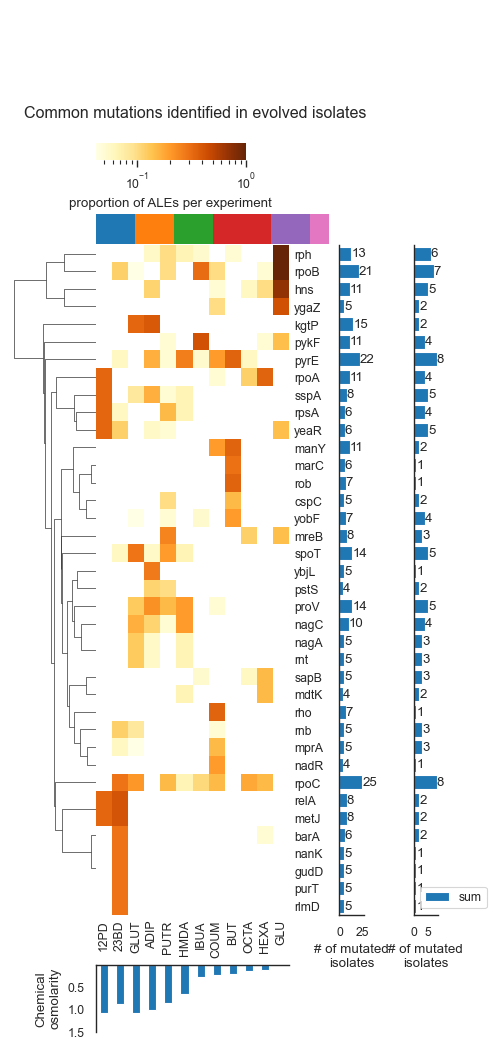

In [249]:
plt.rcParams["figure.dpi"] = 100
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = sns.clustermap(
    chem_mut_table_ratio[col_order],
    cmap="YlOrBr",
    col_cluster=False,
    row_cluster=True,

        figsize=(5, 11),
    cbar_kws={'label': 'proportion of ALEs per experiment', 'orientation':'horizontal'},
    cbar_pos=(0.2, 0.85, 0.3, 0.015),
    col_colors=[col_col],
  #  row_colors=temp.cog_color,

#    dendrogram_ratio=0.1
    norm=LogNorm()
)
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)


barplot_padding = 0.5
osmo_barplot_padding = 0.5


heatmap_space = make_axes_locatable(cm.ax_heatmap)
col_colors_space = make_axes_locatable(cm.ax_col_colors)

mut_cnt_ax = heatmap_space.append_axes("right", size="12.5%", pad=barplot_padding)
cond_cnt_ax = heatmap_space.append_axes("right", size="12.5%", pad=barplot_padding)
nax_col_clrs = col_colors_space.new_horizontal(size="25%", pad=barplot_padding)

osmolarity_ax = heatmap_space.append_axes("bottom", size="10%", pad=osmo_barplot_padding)
row_dendo_space = make_axes_locatable(cm.ax_row_dendrogram)

# nax_osmolarity = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding)

# pack_start describes on what end the dendogram padding is applied
nay = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding, pack_start=True)  

# Sort the values for the bar plot to have the same order as clusters
cm_y_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_yticklabels())]
mut_feat_sum_df = mut_feat_sum_df.reindex(cm_y_tick_order)
ax = mut_feat_sum_df.plot.barh(rot=0, stacked=True, ax=mut_cnt_ax, width=0.8)
ax.bar_label(ax.containers[0])
mut_cnt_ax.spines['top'].set_visible(False)
mut_cnt_ax.spines['right'].set_visible(False)
mut_cnt_ax.set_ylim(-0.5,len(chem_mut_table_ratio.index)-0.5)  # needed to align bar-plots with clustermap residues
mut_cnt_ax.set_yticklabels([])
mut_cnt_ax.invert_yaxis()
mut_cnt_ax.set_xlabel("# of mutated\nisolates")
mut_cnt_ax.get_legend().remove()

#Add one more bar for mut freq

cnd_sum_df = cnd_sum_df.reindex(cm_y_tick_order)
ax3 = cnd_sum_df.plot.barh(rot=0, stacked=True, ax=cond_cnt_ax, width=0.8)
ax3.bar_label(ax3.containers[0])
cond_cnt_ax.spines['top'].set_visible(False)
cond_cnt_ax.spines['right'].set_visible(False)
cond_cnt_ax.set_ylim(-0.5,len(chem_mut_table_ratio.index)-0.5)  # needed to align bar-plots with clustermap residues
cond_cnt_ax.set_yticklabels([])
cond_cnt_ax.invert_yaxis()
cond_cnt_ax.set_xlabel("# of mutated\nisolates")
#cond_cnt_ax.get_legend().remove()



#Add one more bar 
cm_x_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_xticklabels())]
final_conc=final_conc.reindex(cm_x_tick_order)
ax2 = final_conc.plot.bar(rot=0, stacked=True, ax=osmolarity_ax)
#osmolarity_ax.bar_label(osmolarity_ax.containers[0], rotation=90)

osmolarity_ax.invert_yaxis()
osmolarity_ax.spines['bottom'].set_visible(False)
osmolarity_ax.spines['right'].set_visible(False)
osmolarity_ax.set_ylabel("Chemical\nosmolarity")
osmolarity_ax.set_yticks([0.5, 1, 1.5])
osmolarity_ax.get_legend().remove()
osmolarity_ax.xaxis.set_visible(False)

col=cm.ax_col_dendrogram.get_position()
#cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.75, col.height*0.2])

col2=cm.ax_row_dendrogram.get_position()

#cm.ax_row_dendrogram.set_position([col2.x0, 0.17, col2.x1, col2.y1])










cm.fig.suptitle("Common mutations identified in evolved isolates",
                y=0.9,
                x=0.4
               )

In [126]:
cm.savefig('../Plots/Figure 2_cluster.svg')

In [90]:
chem_mut_table_ratio.index

Index(['nagC', 'nagA', 'ybjL', 'rpsA', 'hns', 'rnb', 'sapB', 'marC', 'rnt',
       'mdtK', 'pykF', 'yeaR', 'manY', 'cspC', 'yobF', 'purT', 'kgtP', 'proV',
       'ygaZ', 'mprA', 'relA', 'rlmD', 'barA', 'gudD', 'nanK', 'sspA', 'mreB',
       'rpoA', 'pyrE', 'rph', 'spoT', 'pstS', 'rho', 'metJ', 'rpoB', 'rpoC',
       'nadR', 'rob'],
      dtype='object')

In [205]:
temp = noglu_group[noglu_group.mut_type=="chem-specific"].sort_values(by="sum", ascending=False)

In [206]:
temp_df = pd.DataFrame()
temp_df['sum']=temp['sum']
temp_df['cond']=""
for i in temp.index:
    temp_df.loc[i,'gene_name'] = gene_table[gene_table.gene_name==i].gene_product.values[0]  
    
    cond = temp.T[temp.loc[i]==1.0].index.to_list()
    for j in cond:
        if temp_df.loc[i,'cond']!="":
            temp_df.loc[i,'cond']=temp_df.loc[i,'cond']+', '+j
        else:
            temp_df.loc[i,'cond']=j
    
          
temp_df=temp_df.rename(columns={'sum':'mut_cond'})

In [207]:
temp_df

,mut_cond,cond,gene_name
kgtP,2.0,"GLUT, ADIP",alpha-ketoglutarate:H(+) symporter
relA,2.0,"12PD, 23BD",GDP/GTP pyrophosphokinase
metJ,2.0,"12PD, 23BD",DNA-binding transcriptional repressor MetJ
ybjL,1.0,"ADIP, sum",putative transport protein YbjL
marC,1.0,"BUT, sum",inner membrane protein MarC
purT,1.0,"23BD, sum",phosphoribosylglycinamide formyltransferase 2
rlmD,1.0,"23BD, sum",23S rRNA m(5)U1939 methyltransferase
gudD,1.0,"23BD, sum",D-glucarate dehydratase
nanK,1.0,"23BD, sum",N-acetylmannosamine kinase
rho,1.0,"COUM, sum",transcription termination factor Rho


In [204]:
temp_df[['gene_name','mut_cond','cond']]

,gene_name,mut_cond,cond
rpoC,RNA polymerase subunit beta',8.0,"23BD, GLUT, PUTR, HMDA, IBUA, COUM, OCTA, HEXA"
pyrE,orotate phosphoribosyltransferase,8.0,"23BD, ADIP, PUTR, HMDA, IBUA, COUM, BUT, OCTA"
proV,glycine betaine ABC transporter ATP binding su...,5.0,"GLUT, ADIP, PUTR, HMDA, COUM"
spoT,bifunctional (p)ppGpp synthase/hydrolase SpoT,5.0,"23BD, GLUT, ADIP, PUTR, HMDA"
sspA,stringent starvation protein A,5.0,"12PD, GLUT, ADIP, PUTR, HMDA"
rpoA,RNA polymerase subunit alpha,4.0,"12PD, COUM, OCTA, HEXA"
nagC,DNA-binding transcriptional dual regulator NagC,4.0,"GLUT, ADIP, PUTR, HMDA"
rpsA,30S ribosomal subunit protein S1,4.0,"12PD, 23BD, PUTR, HMDA"
yobF,DUF2527 domain-containing protein YobF,4.0,"GLUT, PUTR, IBUA, BUT"
nagA,N-acetylglucosamine-6-phosphate deacetylase,3.0,"GLUT, ADIP, HMDA"


In [115]:
temp.loc[i,'cond']

array(['23BD', 'GLUT', 'PUTR', 'IBUA', 'COUM', 'HEXA', 'GLU'],
      dtype=object)

In [109]:
temp = noglu_group[noglu_group.mut_type=="general"].sort_values(by="sum", ascending=False)
for i in temp.index:
    print(i, temp.T[temp.loc[i]==1.0].index.values)

rpoC ['23BD' 'GLUT' 'PUTR' 'HMDA' 'IBUA' 'COUM' 'OCTA' 'HEXA']
pyrE ['23BD' 'ADIP' 'PUTR' 'HMDA' 'IBUA' 'COUM' 'BUT' 'OCTA']
proV ['GLUT' 'ADIP' 'PUTR' 'HMDA' 'COUM']
spoT ['23BD' 'GLUT' 'ADIP' 'PUTR' 'HMDA']
sspA ['12PD' 'GLUT' 'ADIP' 'PUTR' 'HMDA']
rpoA ['12PD' 'COUM' 'OCTA' 'HEXA']
nagC ['GLUT' 'ADIP' 'PUTR' 'HMDA']
rpsA ['12PD' '23BD' 'PUTR' 'HMDA']
yobF ['GLUT' 'PUTR' 'IBUA' 'BUT']
nagA ['GLUT' 'ADIP' 'HMDA']
mprA ['23BD' 'GLUT' 'COUM']
rnt ['GLUT' 'ADIP' 'HMDA']
sapB ['IBUA' 'OCTA' 'HEXA']
rnb ['23BD' 'GLUT' 'COUM']
manY ['COUM' 'BUT']
cspC ['PUTR' 'BUT']
mdtK ['HMDA' 'HEXA']
barA ['23BD' 'HEXA']
pstS ['ADIP' 'PUTR']


In [185]:
noglu_group = noglu_group.drop(index=noglu_group[noglu_group.GLU!=0].index, columns="GLU")
noglu_group=noglu_group.sort_values(by='sum', ascending =False)
noglu_group

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type
rpoC,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,8.0,general
pyrE,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,8.0,general
spoT,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general
sspA,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general
proV,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,general
nagC,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general
yobF,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,general
rpsA,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general
rpoA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,general
nagA,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,general


In [206]:
Mutation_dict = {
    'rpoC':'Tc/Tl machineries',
    'pyrE':'Metabolism',
    'spoT':'Stress signaling',
    'sspA':'Stress signaling',
    'proV':'Transport',
    'nagC':'Membrane components',
    'yobF':'Stress signaling',
    'rpsA':'Tc/Tl machineries',
    'rpoA':'Tc/Tl machineries',
    'nagA':'Membrane components',    
    'mprA':'Transport',
    'rnt':'Tc/Tl machineries',
    'rnb':'Tc/Tl machineries',
    'sapB':'Transport',    
    'barA':'Stress signaling',
    'metJ':'Metabolism',
    'pstS':'Transport',
    'mdtK':'Transport',
    'manY':'Transport',
    'kgtP':'Transport',
    'rlmD':'Tc/Tl machineries',    
    'gudD':'Metabolism',    
    'nanK':'Membrane components',
    'purT':'Metabolism',    
    'marC':'Stress signaling',
    'rho':'Tc/Tl machineries',
    'ybjL':'Transport',
'nadR':'Metabolism',
    'rob':'Stress signaling', 
        'cspC':'Stress signaling',
        'relA':'Stress signaling',



}

#For genetic regions
Mutation_dict = {
    'sapF-sapA':'Transport',
    'proV-proX':'Transport',
    'spoT':'Stress signaling',
    'rpoA-rpsD':'TX/TL machineries',
    'sspA':'Stress signaling',
    'mrdB-rsfS':'Membrane components',
    'nagC-nagA':'Membrane components',
    'rpsA':'TX/TL machineries',
    'tufA-rpsL':'TX/TL machineries',
    'pnp-nusA':'TX/TL machineries',
    'cspC-yobF':'Stress signaling',
    'rnt-lhr':'TX/TL machineries',
    'rnb':'TX/TL machineries',
    'mprA-emrB':'Transport',
    'pstB-pstS':'Transport',
    'metJ':'Metabolism',
    'relA':'Stress signaling',
    'barA':'Stress signaling',
    'kgtP':'Transport',
    'manY':'Transport',
    'gudD':'Metabolism',
    'nanK':'Membrane components',
    'rlmD':'TX/TL machineries',
    'purT':'Metabolism',
    'marC':'Membrane components',
    'rho':'TX/TL machineries',
    'ybjL':'Transport',
    'rob':'Stress signaling',
'insN-insI1':'No information',
'atpI':'Metabolism',
'gtrS':'Membrane components',
'yedP':'Metabolism',
'rpoS':'Stress signaling',
'ptsP':'Transport',
    'nadR':'Metabolism',
        'mdtK':'Transport'


}

In [207]:
mut_feat_sum_df[mut_feat_sum_df['sum']==4]

,sum
pstS,4
mdtK,4
nadR,4


In [208]:
noglu_group['function']=noglu_group.index.map(Mutation_dict)

In [209]:
noglu_group

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
rpoC,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,8.0,general,Tc/Tl machineries
pyrE,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,8.0,general,Metabolism
spoT,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general,Stress signaling
sspA,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general,Stress signaling
proV,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,general,Transport
nagC,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general,Membrane components
yobF,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,general,Stress signaling
rpsA,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general,Tc/Tl machineries
rpoA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,general,Tc/Tl machineries
nagA,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,general,Membrane components


In [210]:
noglu_group['function'].unique()

array(['Tc/Tl machineries', 'Metabolism', 'Stress signaling', 'Transport',
       'Membrane components'], dtype=object)

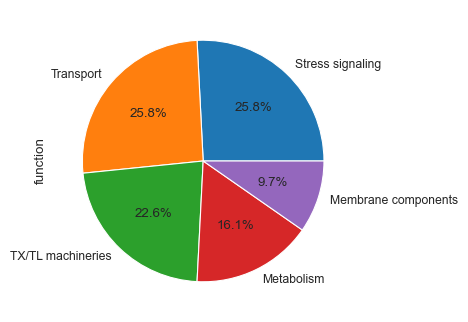

In [191]:
ax=noglu_group.function.value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.get_figure().savefig("./total_pie.svg")

In [192]:
print("General tolerance regions: ",noglu_group[noglu_group.mut_type=='general'].index.size," Chemical specific regions: ",noglu_group[noglu_group.mut_type=='chem-specific'].index.size)

General tolerance regions:  19  Chemical specific regions:  12


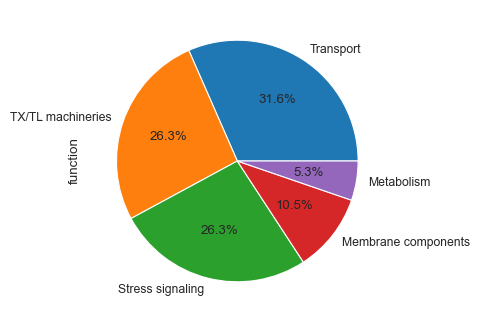

In [193]:
ax=noglu_group[noglu_group.mut_type=='general'].function.value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.get_figure().savefig("./genera_pie.svg")

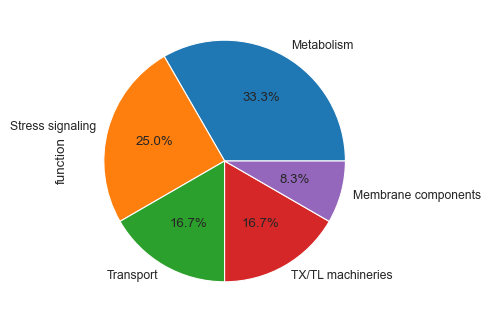

In [194]:
ax=noglu_group[noglu_group.mut_type=='chem-specific'].function.value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.get_figure().savefig("./specific_pie.svg")

In [205]:
noglu_group.function.value_counts()

Stress signaling       8
Transport              8
TX/TL machineries      7
Metabolism             5
Membrane components    3
Name: function, dtype: int64

In [212]:
noglu_group.index.size

31

In [213]:
8/31

0.25806451612903225

In [201]:
noglu_group[noglu_group.mut_type=='general']['function'].value_counts()

Transport              6
TX/TL machineries      5
Stress signaling       5
Membrane components    2
Metabolism             1
Name: function, dtype: int64

In [203]:
noglu_group[noglu_group.mut_type=='chem-specific'].sort_values(by='sum')

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
rlmD,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,TX/TL machineries
gudD,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism
nanK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Membrane components
purT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism
marC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,chem-specific,Stress signaling
rho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,chem-specific,TX/TL machineries
ybjL,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Transport
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism
rob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,chem-specific,Stress signaling
metJ,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,chem-specific,Metabolism


In [195]:
noglu_group[noglu_group.function=='Transport']

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
proV,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,general,Transport
mprA,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,general,Transport
sapB,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,general,Transport
pstS,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,general,Transport
mdtK,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,general,Transport
manY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,general,Transport
kgtP,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,chem-specific,Transport
ybjL,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Transport


In [196]:
noglu_group[noglu_group.function=='Stress signaling']

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
spoT,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general,Stress signaling
sspA,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,general,Stress signaling
yobF,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,general,Stress signaling
barA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,general,Stress signaling
cspC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,general,Stress signaling
relA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,chem-specific,Stress signaling
marC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,chem-specific,Stress signaling
rob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,chem-specific,Stress signaling


In [197]:
noglu_group[noglu_group.function=='TX/TL machineries']

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
rpoC,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,8.0,general,TX/TL machineries
rpsA,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general,TX/TL machineries
rpoA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,general,TX/TL machineries
rnt,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,general,TX/TL machineries
rnb,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,general,TX/TL machineries
rlmD,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,TX/TL machineries
rho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,chem-specific,TX/TL machineries


In [168]:
noglu_group[noglu_group.function=='Membrane components']

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
nagC,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,general,Membrane components
nagA,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,general,Membrane components
nanK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Membrane components


In [169]:
noglu_group[noglu_group.function=='Metabolism']

,12PD,23BD,GLUT,ADIP,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,sum,mut_type,function
pyrE,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,8.0,general,Metabolism
metJ,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,chem-specific,Metabolism
gudD,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism
purT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,chem-specific,Metabolism


In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index].sort_values(by='count_sum', ascending=False).count_suma

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='chem-specific'].index].sort_values(by='count_sum', ascending=False).count_sum

In [ ]:
temp = noglu_group[noglu_group.mut_type=='general'].sort_values(by='sum', ascending=False)

In [ ]:
temp

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index].boxplot('count_sum')

In [198]:
noglu_group[noglu_group.mut_type=='general']['sum'].mean()

3.789473684210526

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='general'].index]['count_sum'].mean()

In [ ]:
noglu_group[noglu_group.mut_type=='chem-specific'].sort_values(by='sum', ascending=False)

In [ ]:
noglu_group[noglu_group.mut_type=='chem-specific'].sort_values(by='sum', ascending=False)

In [ ]:
mut_table.loc[noglu_group[noglu_group.mut_type=='chem-specific'].index].boxplot('count_sum')

In [ ]:
noglu_group[noglu_group.function=="Transport"]